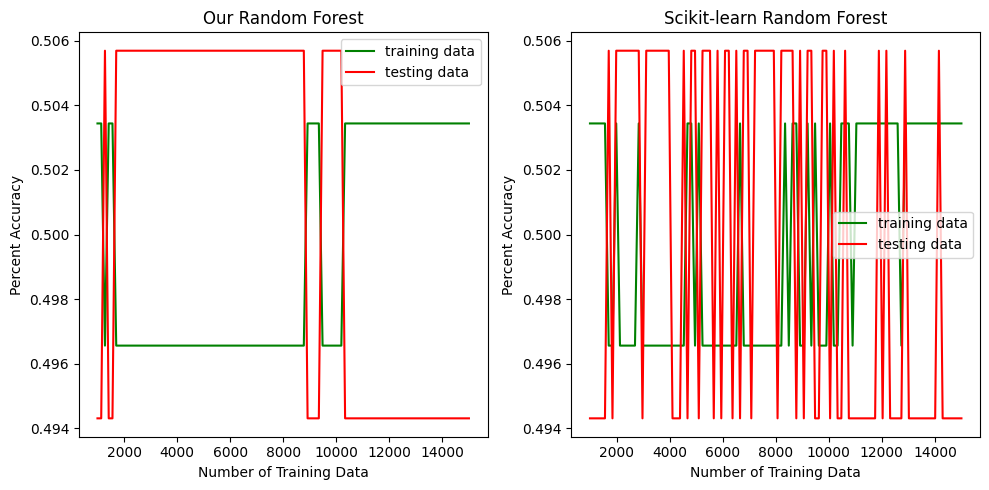

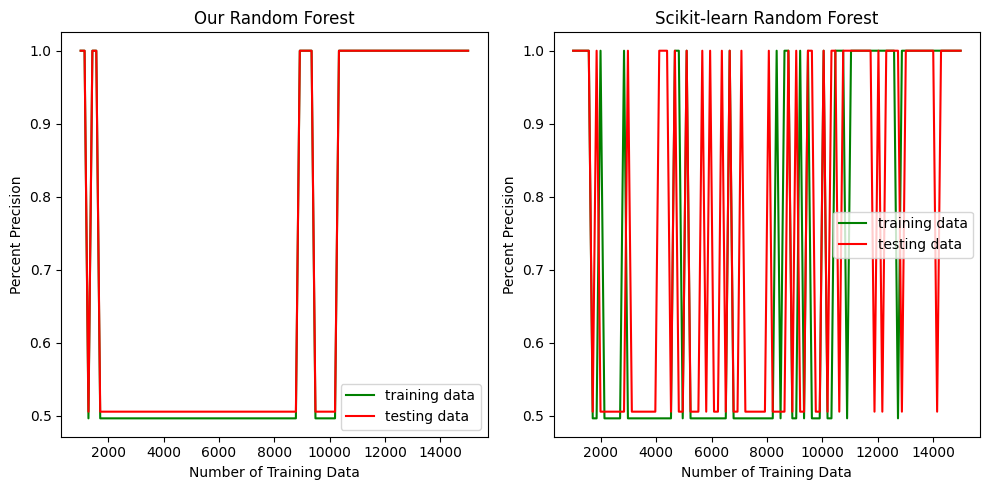

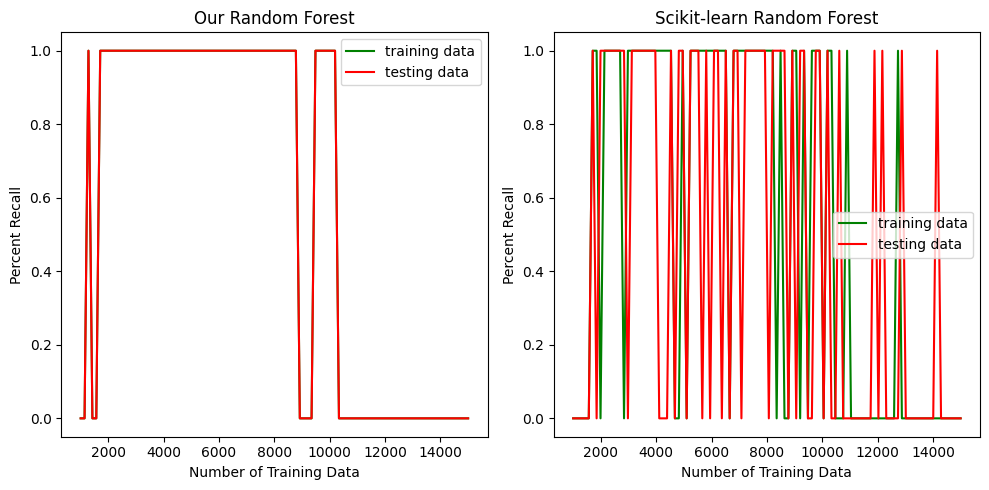

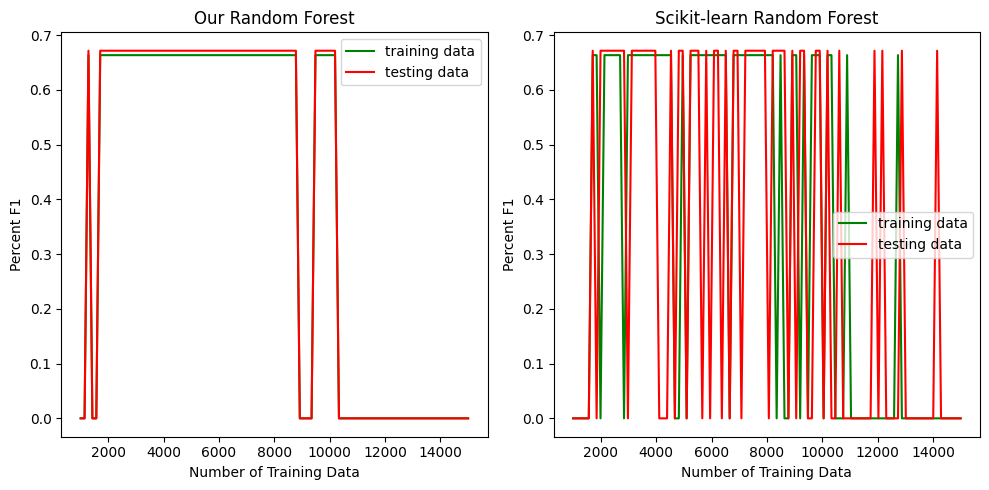

In [1]:
from id3 import *
from imdbDataSet import *
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def random_forest(x_train, y_train, x_test, y_test, fv_skip_top, fv_length, tree_number, tree_fv_length, min_samples_split=2, max_depth=np.inf):
    #create encoded feature vector (index of words)
    encoded_feature_vector = imdb.getFeatureVector(skip_top=fv_skip_top, num_words=fv_length)

    #each tree has a feature vector smaller than the original
    #choose each attribute at random
    encoded_tree_feature_vectors = [np.random.choice(encoded_feature_vector, tree_fv_length, replace=False) for _ in range(tree_number)]

    #create 0-1 feature vector for each training example
    train_examples = np.zeros((len(x_train), len(encoded_feature_vector)))
    for i, xi in enumerate(x_train):
        train_examples[i, np.isin(encoded_feature_vector, xi)] = 1

    #create 0-1 feature vector for each test example
    test_examples = np.zeros((len(x_test), len(encoded_feature_vector)))
    for i, xi in enumerate(x_test):
        test_examples[i, np.isin(encoded_feature_vector, xi)] = 1

    #create ID3 forest for the ensemble
    forest = [ID3(features=efv, min_samples_split=min_samples_split, max_depth=max_depth) for efv in encoded_tree_feature_vectors]
    for tree in forest:
        tree.fit(train_examples, np.array(y_train))

    #collect test example predictions from the forest
    all_tree_predictions = np.array([tree.predict(test_examples) for tree in forest])

    #organize each tree's prediction to be calculated
    tree_votes = all_tree_predictions.sum(axis=0)

    #implement majority vote for each example
    majority_outcome = np.where(tree_votes / tree_number > 0.5, 1, 0)
    majority_outcome[tree_votes / tree_number == 0.5] = np.random.randint(0, 2, size=(tree_votes / tree_number == 0.5).sum())

    #create SciLearn random forest classifier for comparison
    sl_random_forest = RandomForestClassifier(n_estimators=tree_number)
    sl_random_forest.fit(train_examples,np.array(y_train))
    sl_random_forest_pred = sl_random_forest.predict(test_examples)

    return y_test, majority_outcome, sl_random_forest_pred

#Ορισμός υπερπαραμέτρων
sys.setrecursionlimit(3000)

train_step = np.linspace(1000,25000,50,dtype=int)
tree_number = 5
fv_skip_top = 250
fv_length = 200
tree_fv_length = 50
min_samples_split = 2
max_depth = 30 #must be less or equal than tree_fv_length


#obtain imdb data 
imdb = IMDB()
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = imdb.getTrainingData(skip_top=fv_skip_top, num_words=fv_length)

#initialize metrics
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

our_results = {metric: {'train': [], 'test': []} for metric in metrics}
scilearn_results = {metric: {'train': [], 'test': []} for metric in metrics}

for step in train_step:
    x_train = x_train_raw[:step]
    y_train = y_train_raw[:step]

    #training data tests
    y_test_train, y_pred_train_our, y_pred_train_scilearn = random_forest(x_train=x_train, y_train=y_train, x_test=x_train_raw, y_test=y_train_raw, fv_skip_top=fv_skip_top, fv_length=fv_length,tree_number=tree_number,tree_fv_length=tree_fv_length, min_samples_split=min_samples_split,max_depth=max_depth)
    
    #testing data tests
    y_test_test, y_pred_test_our, y_pred_test_scilearn = random_forest(x_train=x_train, y_train=y_train, x_test=x_test_raw, y_test=y_test_raw, fv_skip_top=fv_skip_top, fv_length=fv_length,tree_number=tree_number,tree_fv_length=tree_fv_length, min_samples_split=min_samples_split,max_depth=max_depth)
    
    for metric, func in metrics.items():
        #calculate metrics for our implementation
        if metric == 'precision':
            our_results[metric]['train'].append(func(y_true=y_test_train, y_pred=y_pred_train_our, zero_division=1))
            our_results[metric]['test'].append(func(y_true=y_test_test, y_pred=y_pred_test_our, zero_division=1))
        else:
            our_results[metric]['train'].append(func(y_true=y_test_train, y_pred=y_pred_train_our))
            our_results[metric]['test'].append(func(y_true=y_test_test, y_pred=y_pred_test_our))

        #calculate metrics for scilearn implementation
        if metric == 'precision':
            scilearn_results[metric]['train'].append(func(y_true=y_test_train, y_pred=y_pred_train_scilearn, zero_division=1))
            scilearn_results[metric]['test'].append(func(y_true=y_test_test, y_pred=y_pred_test_scilearn, zero_division=1))
        else:
            scilearn_results[metric]['train'].append(func(y_true=y_test_train, y_pred=y_pred_train_scilearn))
            scilearn_results[metric]['test'].append(func(y_true=y_test_test, y_pred=y_pred_test_scilearn))

# Plot results
for metric in metrics.keys():
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Subplot for our implementation
    axs[0].plot(train_step, our_results[metric]['train'], color='green', label='training data')
    axs[0].plot(train_step, our_results[metric]['test'], color='red', label='testing data')
    axs[0].set_title('Our Random Forest')
    axs[0].set_xlabel('Number of Training Data')
    axs[0].set_ylabel(f'Percent {metric.capitalize()}')
    axs[0].legend()

    # Subplot for scikit-learn implementation
    axs[1].plot(train_step, scilearn_results[metric]['train'], color='green', label='training data')
    axs[1].plot(train_step, scilearn_results[metric]['test'], color='red', label='testing data')
    axs[1].set_title('Scikit-learn Random Forest')
    axs[1].set_xlabel('Number of Training Data')
    axs[1].set_ylabel(f'Percent {metric.capitalize()}')
    axs[1].legend()

    # Display the figure with the subplots
    plt.tight_layout()
    plt.show()

